### Alter the surface data file to delimit three tropical PFTs

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import rioxarray as rx
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

from cartopy.io.shapereader import Reader
import shapefile
from shapely.geometry import shape, Point, LinearRing

import regionmask

from shapely.geometry import MultiPolygon, Polygon

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Surface data file
Read in the defaut global file

In [2]:
surf = '/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/surfdata_4x5_simyr2000_c130927.nc'
surf = xr.open_dataset(surf, decode_times=False)

In [3]:
fates = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/apr24/fbnc_f45_v3_rdark_vert_1.E5e483733fa-F77ac7623.2024-04-24/run/fbnc_f45_v3_rdark_vert_1.E5e483733fa-F77ac7623.2024-04-24.2190s.nc'
fates = xr.open_dataset(fates, decode_times=False)
fates_lon = fates.coords['lon']
fates_lat = fates.coords['lat']

In [4]:
# Rename lat and lon and assign coordinates
surf = surf.rename({'lsmlat': 'lat', 'lsmlon':'lon'})
surf = surf.assign_coords({'lon':fates_lon})
surf = surf.assign_coords({'lat':fates_lat})

### Plot them 

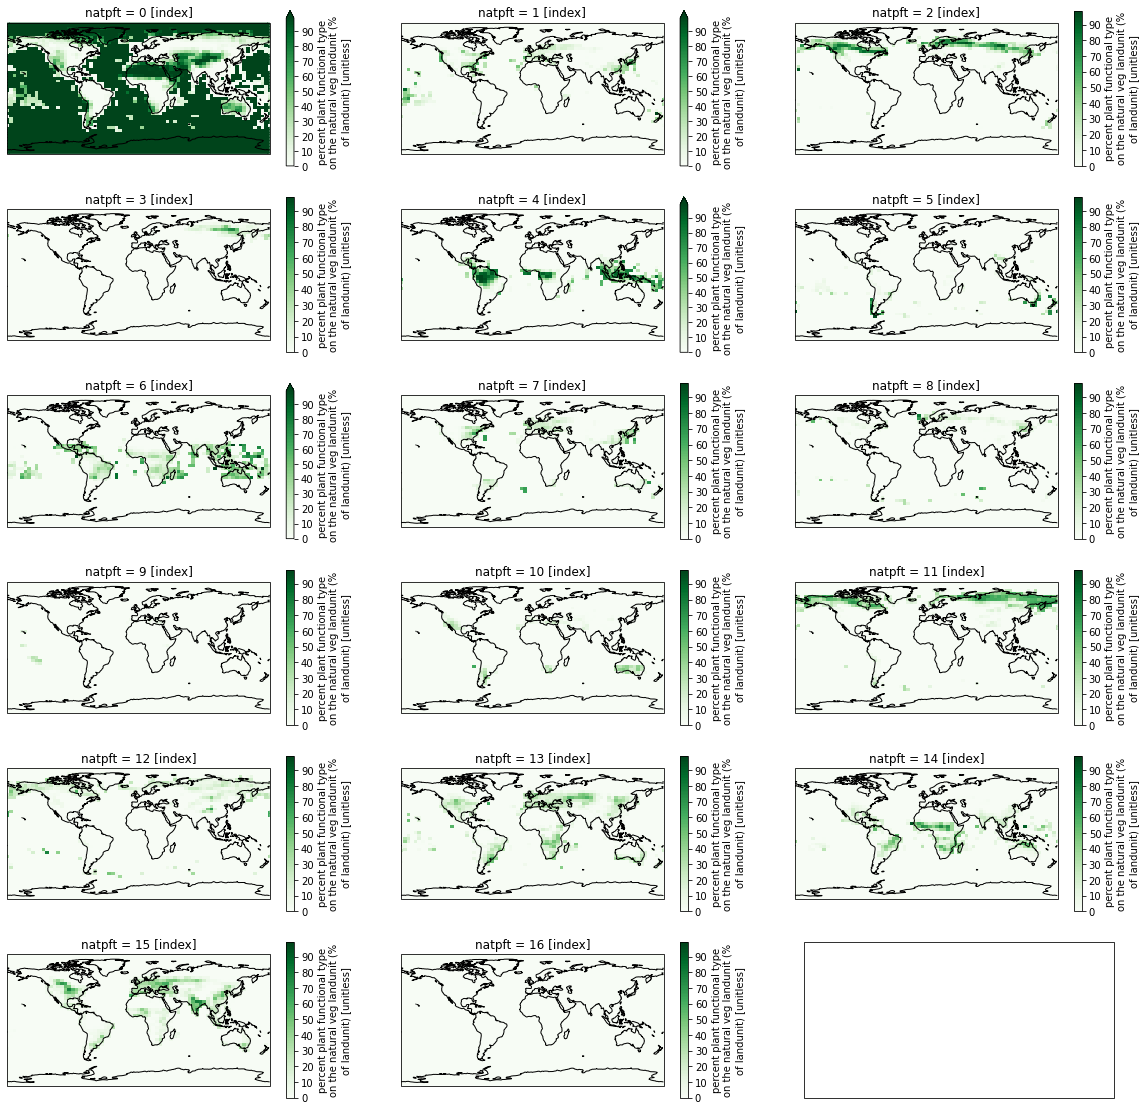

In [5]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,20))
axs = axs.flatten()

clevs=np.arange(0,100,1)

for i in range(0,17):
    cs = surf.PCT_NAT_PFT.isel(natpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i])
    axs[i].coastlines()


### PFT mapping
HLM PFT 4 = American tropical broadleaf evergreen (fates pft 0 )
HLM PFT 6 = American tropical broadleaf deciduous (fates pft 3 )
HLM PFT 4 = African tropical broadleaf evergreen (fates pft 1 )
HLM PFT 6 = African tropical broadleaf deciduous (fates pft 4 )
HLM PFT 4 = Asian tropical broadleaf evergreen (fates pft 2 )
HLM PFT 6 = Asian tropical broadleaf deciduous (fates pft 5 )
HLM PFT 14 = C4 grass (fates pft 6 )

### Crop to just the tropics

In [6]:
cropped_surf = surf.isel(lat=slice(15,31))

#### 1. Copy HLM pft 4 to pfts  1,2,3 and HLM pft 6 to pfts 4,5,6

In [7]:
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=1)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=4)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=2)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=4)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=3)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=4)

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=4)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=6)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=5)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=6)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=6)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=6)

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=7)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=14)

#### 4. Zero out all the other pfts

In [8]:
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=8)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=9)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=10)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=11)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=12)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=13)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=14)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=15)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=16)] = 0

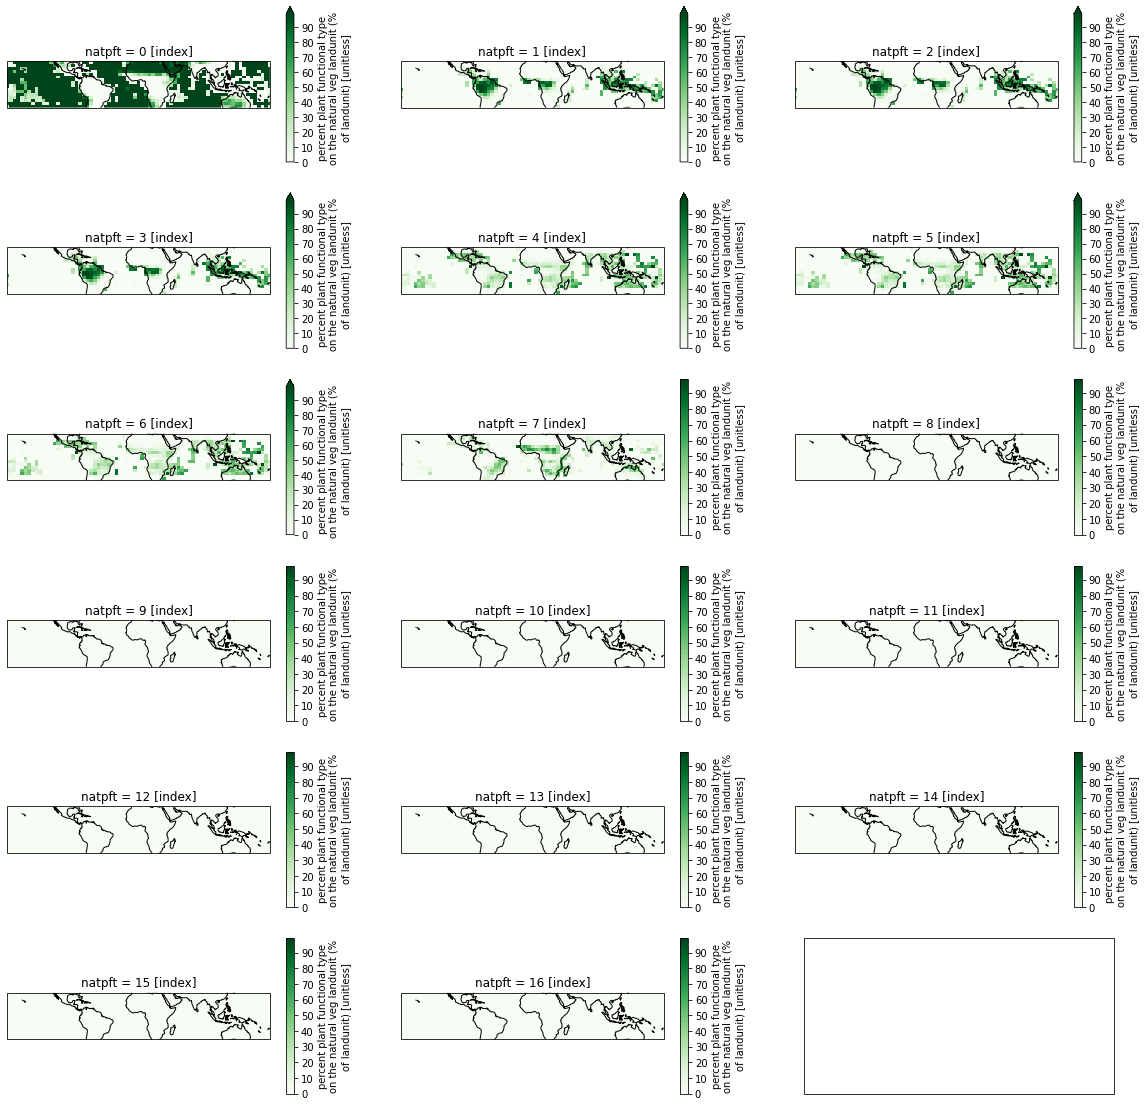

In [9]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,20))
axs = axs.flatten()

clevs=np.arange(0,100,1)

for i in range(0,17):
    cs = cropped_surf.PCT_NAT_PFT.isel(natpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i])
    axs[i].coastlines()


#### 5. Zero out PFTs  1 and  4 outside americas

In [10]:
#min_lon_index = 37
#max_lon_index = 69

# use actual lon values (not indices)
min_lon_index = 185
max_lon_index = 345

lon_mask = (cropped_surf.lon >= min_lon_index) & (cropped_surf.lon <= max_lon_index) 
mask = lon_mask

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=1)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=1).where(mask, 0)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=4)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=4).where(mask, 0)

#### 6. zero out PFTs 2 and 5 outside africa

In [11]:
min_lon_index = 0
max_lon_index = 65
min_lon_index2 = 345
max_lon_index2 = 360

lon_mask = (cropped_surf.lon >= min_lon_index) & (cropped_surf.lon <= max_lon_index)
lon_mask2 = (cropped_surf.lon >= min_lon_index2) & (cropped_surf.lon <= max_lon_index2)

mask = lon_mask | lon_mask2

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=2)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=2).where(mask, 0)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=5)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=5).where(mask, 0)

#### 7. zero out PFts 3 and 6 outside asia 

In [12]:
min_lon_index = 65
max_lon_index = 185

lon_mask = (cropped_surf.lon >= min_lon_index) & (cropped_surf.lon <= max_lon_index) 
mask = lon_mask

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=3)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=3).where(mask, 0)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=6)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=6).where(mask, 0)

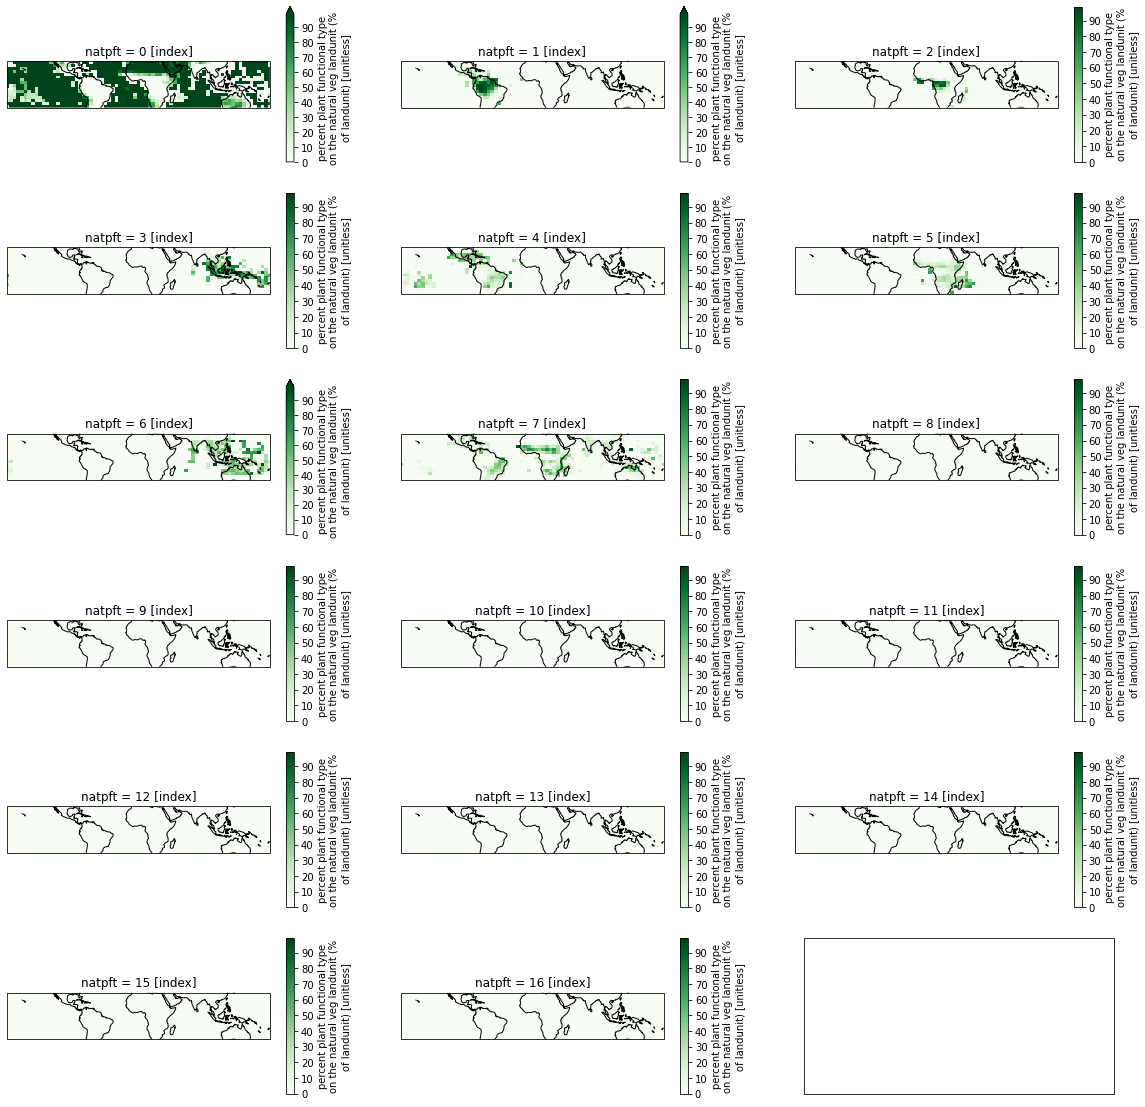

In [13]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,20))
axs = axs.flatten()

clevs=np.arange(0,100,1)

for i in range(0,17):
    cs = cropped_surf.PCT_NAT_PFT.isel(natpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i])
    axs[i].coastlines()


### revert the lat lon  dimensions 

In [14]:
cropped_surf = cropped_surf.rename({'lat': 'lsmlat', 'lon':'lsmlon'})

In [15]:
# save the new file 
cropped_surf.to_netcdf('/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/surf_nocomp.nc')
